### Goal
Build a multi linear regression model using the GTEx data. The model receives all combinations of pairs of tissues (X,Y) per invidividual. 

### TODO
1. Data
    - 1.1 Metadata
    - 1.2 Sparsity of the data
    - 1.3 Raw counts to FPKMs
2. Compute baseline model - tissue mean acrross individuals
3. Normalize data
4. Cross Tissue Matrix computation
5. Compute Linear Regression

### Conclusions
- still missing


In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sklearn.metrics import *
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.decomposition import MiniBatchSparsePCA

from rep import preprocessing as p
from rep.linear_regression import Linear_Regression
from rep.linear_regression import Transform
from rep.linear_regression import FeatureReduction
from rep import evaluate as e



### 1. Data


In [3]:
os.getcwd()

'/data/nasif12/home_if12/giurgiu/rep_gagneur/rep/notebooks/models'

In [2]:
# load gtex summarized experiment
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex.h5ad")
gtex = p.load(file)

# load invidivudals
path = os.path.join("..","..","data","processed","gtex","recount")

train = []
valid = []
test = []
states = ['train','valid','test']
dict_states_indiv = {'train':train,'valid':valid,'test':test}

for s in states:
    with open(os.path.join(path,s+"_individuals.txt"), 'r') as f:
        for l in f: dict_states_indiv[s].append(l.replace("\n",""))
            
# remove genes with no counts accross all tissues and invididuals
zero_elem = np.where(~gtex.X.any(axis=1))[0]

# remove noncoding genes
protein_coding = []
with open(os.path.join(os.readlink(os.path.join("..","..","data")),"raw","annotation","gencode_v25_protein_coding_genes.txt")) as f:
    for line in f: protein_coding.append(line.replace("\n","").split(".")[0])

tokeep = [gene for i,gene in enumerate(gtex.obs_names) if i not in zero_elem and gene.split(".")[0] in protein_coding]
filtered_gtex = gtex[tokeep]
del gtex, zero_elem

p.save(filtered_gtex,os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_filtered.h5ad"))

'/s/project/rep/processed/gtex/recount/recount_gtex_filtered.h5ad'

#### 1.1 Metadata
Save the description of the files

In [11]:
dict = {}
dict['train'] = {'samples':samples_description_train,'genes':gene_id_train.tolist()}
dict['valid'] = {'samples':samples_description_valid,'genes':gene_id_valid.tolist()}
dict['test'] = {'samples':samples_description_test,'genes':gene_id_test.tolist()}
p.writeJSON(dict,os.path.join(path,'metadata.json'))

#### 1.2 Sparsity of the data

In [10]:
# percent of sparsity of Xs
size = filtered_gtex.X.shape[0]*filtered_gtex.X.shape[1]
(size - np.count_nonzero(np.array(filtered_gtex.X)))/(size)

0.3367858144856668

#### 1.3 Raw counts to FPKMs
Normalize data to FPKMs. (Counts of mapped fragments * 1000 * 1000) / (Length of transcript * Total Count of mapped fragments)

- Counts of mapped fragments = counts for one gene x one sample
- Length of transcripts = choose per gene the transcript with most exons and get the length of the exonic regions
- Total Count of mapped fragments = total counts per sample

In [3]:
# extract annotation for genes
path = os.path.join(os.readlink(os.path.join("..","..","data")),"raw","annotation")
file = os.path.join(path,"gencode.v25.basic.annotation.gtf")
gene_annotation = p.get_annotation(file)

In [4]:
# check if the annotation is consistent between recount2 and gencode.v25
annotation_recount = filtered_gtex.obs.index.tolist()
for a in annotation_recount:
    if a not in gene_annotation:
        print("Annotation not found: ", a)

In [5]:
# raw counts to FPKM
# (Counts of mapped fragments * 1000 * 1000) / (Length of transcript * Total Count of mapped fragments)
import anndata
x_norm = p.raw_counts2fpkm(filtered_gtex, gene_annotation)
norm_gtex = anndata.AnnData(X=x_norm,obs=filtered_gtex.obs,var=filtered_gtex.var)
p.save(norm_gtex,os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_norm.h5ad"))

'/s/project/rep/processed/gtex/recount/recount_gtex_norm.h5ad'

Plot correlation between raw matrix and normalized matrix

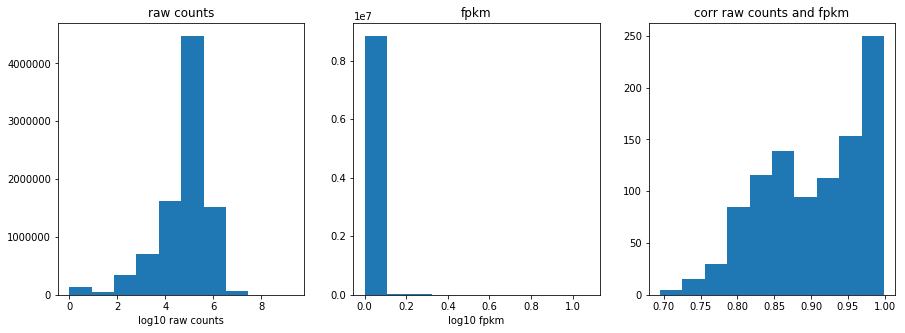

In [9]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
plt.hist(np.log10(filtered_gtex.X[:1000,:] + 1).reshape(1,-1).squeeze())
plt.title("raw counts")
plt.xlabel("log10 raw counts")

fig.add_subplot(132)
plt.hist(np.log10(norm_gtex.X[:1000,:] + 1).reshape(1,-1).squeeze())
plt.title("fpkm")
plt.xlabel("log10 fpkm")

fig.add_subplot(133)
corr_values = pd.Series([spearmanr(filtered_gtex.X[i,:], norm_gtex.X[i, :])[0]  for i in range(1000)])
plt.hist(corr_values.dropna())
plt.title("corr raw counts and fpkm")

plt.show()

### 2. Compute baseline model - tissue mean acrross individuals

In [6]:
def compute_baseline(annobj):
    tissues = annobj.var['Tissue'].drop_duplicates().tolist()
    Y_mean_tissue = np.zeros((len(annobj.obs_names),len(tissues)))
    
    for t in tissues:
        slice_bytissue = annobj[:,annobj.var['Tissue'] == t]    
        mean_value = np.log10(np.mean(np.square(slice_bytissue.X),axis=1)+1)
        Y_mean_tissue[:,tissues.index(t)] = mean_value

    
    return pd.DataFrame(data = Y_mean_tissue, index = annobj.obs_names, columns = tissues) 

baseline_prediction = compute_baseline(norm_gtex)
baseline_prediction.to_pickle(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","baseline","baseline_mean_tissues.pkl"))

In [ ]:
# def compute_baseline(Ys,anndataobj,sample_description,save_name):

#     Y_mean_tissue = np.zeros(Ys.shape)
#     visited = []

#     for i, s in enumerate(sample_description):
#         if s not in visited:
#             tissue = anndataobj.var.loc[s.split("_")[1],'Tissue']
#             ii, ms = zip(*[(k, j) for k,j in enumerate(sample_description) if anndataobj.var.loc[j.split("_")[1],'Tissue'] == tissue])
#             indexes = list(ii)
#             matched_samples = list(ms)
#             mean_value = np.mean(np.square(Ys[indexes,:]),axis=0)
#             new_values =  np.array(mean_value.squeeze() * (Y_mean_tissue[indexes,:].shape[0]))
#             Y_mean_tissue[indexes,:] = new_values
#             visited += matched_samples
#             print(len(visited)," processed out of ", Y_mean_tissue.shape[0])
#     p.writeh5(Y_mean_tissue,"Baseline_valid",save_name)


# path = os.path.join("..","data","processed","gtex","input_data")
# metadata = p.readJSON(dict,os.path.join(path,'metadata.json'))

# path = os.path.join("..","data","processed","models","baseline_mean_tissues")
# compute_baseline(Ys_valid,filtered_gtex,metadata['valid']['samples'],os.path.join(path,"Y_baseline_valid.h5"))
# compute_baseline(Ys_test,filtered_gtex,metadata['test']['samples'],os.path.join(path,"Y_baseline_test.h5"))

### 3. Normalize data


Compute log ratio of the expression change = log10(value) - log10(exp_value=mean_over_individuals_per_tissue)

In [2]:
def to_log_ratio(annobj, baseline_prediction):
    
    x = np.zeros(annobj.X.shape)
    visited = []

    for i, sample in enumerate(annobj.var_names):
        tissue = annobj.var.loc[sample,'Tissue']
        x[:,i] = np.log(annobj[:,sample].X + 1 ) - np.log(baseline_prediction.loc[:,tissue] + 1)
    
    return x
            
x_expression_ratios = to_log_ratio(norm_gtex, baseline_prediction)
norm_gtex.X = x_expression_ratios
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
p.save(norm_gtex,file)

NameError: name 'norm_gtex' is not defined

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
plt.hist(norm_gtex.X[:20000,:].reshape(1,-1).squeeze())
plt.title("log ratios")
plt.xlabel("log ratios(fpkm/mean(tissue))")

### 4. Cross Tissue Matrix computation

Here we compute the Txi_Tyi x Gk, where T - tissue, G - gene, x,y - tissue indexes within one invidividual i, x != y

These will be stored under `/s/project/rep/processed/gtex/input_data/` as `X_train.h5`, `Y_train.h5`, `X_valid.h5`, `Y_valid.h5`, `X_test.h5`, `Y_test.h5`

In [2]:
def cross(norm_gtex):
    # load invidivudals
    path = os.path.join("..","..","data","processed","gtex","recount")

    train = []
    valid = []
    test = []
    states = ['train','valid','test']
    dict_states_indiv = {'train':train,'valid':valid,'test':test}

    for s in states:
        with open(os.path.join(path,s+"_individuals.txt"), 'r') as f:
            for l in f: dict_states_indiv[s].append(l.replace("\n",""))


    selected_genes = norm_gtex.obs_names # training with all features
    print("Total Genes: ",len(selected_genes))

    # compute cross tissue matrix
    (X_train_norm, Y_train_norm, samples_description_train, gene_id_train) = p.rnaseq_cross_tissue(norm_gtex, individuals=train, gene_ids=selected_genes, onlyBlood = True)
    (X_valid_norm, Y_valid_norm, samples_description_valid, gene_id_valid) = p.rnaseq_cross_tissue(norm_gtex, individuals=valid, gene_ids=selected_genes, onlyBlood = True)
    (X_test_norm, Y_test_norm, samples_description_test, gene_id_test) = p.rnaseq_cross_tissue(norm_gtex, individuals=test, gene_ids=selected_genes, onlyBlood = True)
    
    return  (X_train_norm, Y_train_norm, samples_description_train, gene_id_train), (X_valid_norm, Y_valid_norm, samples_description_valid, gene_id_valid), (X_test_norm, Y_test_norm, samples_description_test, gene_id_test)

In [3]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.load(file)
(X_train, Y_train, _, _), (X_valid, Y_valid, _, _), (X_test, Y_test, _, _) = cross(gtex)

Total Genes:  19932
samples_df  (8911, 14)
samples_df_sliced  (5389, 14)
compute all arrangements
Total pairs: 4403
samples_df  (8911, 14)
samples_df_sliced  (1820, 14)
compute all arrangements
Total pairs: 1630
samples_df  (8911, 14)
samples_df_sliced  (1702, 14)
compute all arrangements
Total pairs: 1558


In [5]:
# save
# path = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data")
# p.writeh5(X_train,"X_train",os.path.join(path,"X_train_pc_bloodonly.h5"))
# p.writeh5(Y_train,"Y_train",os.path.join(path,"Y_train_pc_bloodonly.h5"))
# p.writeh5(X_valid,"X_valid",os.path.join(path,"X_valid_pc_bloodonly.h5"))
# p.writeh5(Y_valid,"Y_valid",os.path.join(path,"Y_valid_pc_bloodonly.h5"))
# p.writeh5(X_test,"X_test",os.path.join(path,"X_test_pc_bloodonly.h5"))
# p.writeh5(Y_test,"Y_test",os.path.join(path,"Y_test_pc_bloodonly.h5"))

### 4. Compute linear regression
Here we test various setups for the linear regression.
To begin we will regress over all 20000 pc genes. As input we take the the `X_train, Y_train, X_valid, Y_valid` computed above.
We consider only transitions from **blood** to other tissues.

- (a) use Multiouput Regression
- (b) use Multiouput Regression using batches

For this two setup decide if there its an advantage using one over the other (i.e. runtime, performance).

For optimizing and further testing of this model we will regress over the top 3000 genes (higher spearmann correlation)

In [ ]:
(Xs,Ys,x_scaler,y_scaler) = Transform(X_train,Y_train).fit_transform()
(Xs_valid, Ys_valid) = Transform(X_valid,Y_valid).transform(x_scaler, y_scaler)
(Xs_reduced,pca) = FeatureReduction(Xs).pca_svd(components = 10,fit_transform = True)
(Xs_valid_reduced,_) = FeatureReduction(Xs_valid).pca_svd(components = 10,fit_transform = False, scaler = pca)

- (a) use Multiouput Regression

In [59]:
m = Linear_Regression(Xs_reduced, Ys, Xs_valid_reduced, Ys_valid)
%time pred = m.run(model='train_lassolars_model_multioutput') 

CPU times: user 1min 23s, sys: 19.2 s, total: 1min 42s
Wall time: 24min 16s


R2:  0.01352783481413509


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


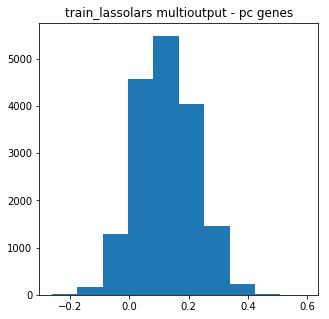

In [60]:
e.rquare_eval(pred,Ys_valid,"train_lassolars multioutput - pc genes")

- (b) use Multiouput Regression with batch - batch size default 300

In [ ]:
m = Linear_Regression(Xs_reduced, Ys, Xs_valid_reduced, Ys_valid)
%time pred = m.run_batches(model='train_lassolars_model_multioutput',n=1000) 

In [ ]:
e.rquare_eval(pred,Ys_valid,"train_lassolars multioutput - pc genes with batch")

In [44]:
pred = np.zeros(Ys_valid.shape)
for i in range(0,1000):
    m = Linear_Regression(Xs_reduced, Ys[:,i], Xs_valid_reduced, Ys_valid[:,i])
    pred[:,i] = m.run('train_lassolars_model')

/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


R2:  -0.014963041766521438


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


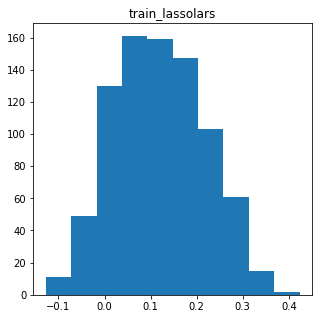

In [45]:
e.rquare_eval(pred[:1000],Ys_valid[:1000],"train_lassolars")

In [15]:
def fit_linear_regression(X_train, Y_train, X_valid, Y_valid, comp = 2):
    
    from rep import evaluate as e
    from sklearn.decomposition import SparsePCA
    
    # Center data to N(0,1) distribution
    x_preproc = StandardScaler()
    y_preproc = StandardScaler()

    Xs = x_preproc.fit_transform(X_train)
    Ys = y_preproc.fit_transform(Y_train)

    Xs_valid = x_preproc.transform(X_valid)
    Ys_valid = y_preproc.transform(Y_valid)
    
    # Feature space reduction
    pca = PCA(n_components = comp, svd_solver='randomized')
#     pca = SparsePCA(n_components = comp, max_iter = 50, random_state = 123)
    
    pca.fit(Xs)
    Xs_pca = pca.transform(Xs)
    Xs_valid_pca = pca.transform(Xs_valid)
    print("Shape of Xs_pca: ", Xs_pca)
    
    # Fit and evaluate
    m = Linear_Regression(Xs_pca, Ys, Xs_valid_pca, Ys_valid)
    pred = m.run('train_lassolars_model')
    e.rquare_eval(pred, Ys_valid, "LassoLars mit feature space reduction using PCA")
    
    return pred

#### 4.1 LogRatio Train dataset +  Feature space reduction
Here we build a linear regression which takes as input the log(fpkm/mean_over_tissue) instead of the raw counts. 
To speed up the training a feature space reduction is needed. The used method is PCA. To generate the results we used the protein_coding genes.

In [4]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.load(file)

In [5]:
(X_train, Y_train, _, _), (X_valid, Y_valid, _, _), (_, _, _, _) = cross(gtex)

Total Genes:  19932
samples_df  (8911, 14)
samples_df_sliced  (5389, 14)
compute all arrangements
Total pairs: 105778
samples_df  (8911, 14)
samples_df_sliced  (1820, 14)
compute all arrangements
Total pairs: 34830
samples_df  (8911, 14)
samples_df_sliced  (1702, 14)
compute all arrangements
Total pairs: 31308


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


R2:  0.0059177324064046966


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 3h 45min 11s, sys: 24min 47s, total: 4h 9min 59s
Wall time: 21min 42s


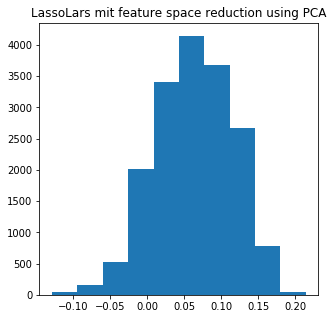

In [6]:
%time pred = fit_linear_regression(X_train, Y_train, X_valid, Y_valid)

Total Genes:  19932
samples_df  (8911, 14)
samples_df_sliced  (5389, 14)
compute all arrangements
Total pairs: 105778
samples_df  (8911, 14)
samples_df_sliced  (1820, 14)
compute all arrangements
Total pairs: 34830
samples_df  (8911, 14)
samples_df_sliced  (1702, 14)
compute all arrangements
Total pairs: 31308
R2:  -0.008742039166043518


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 3h 8min 47s, sys: 13min 15s, total: 3h 22min 2s
Wall time: 18min 1s


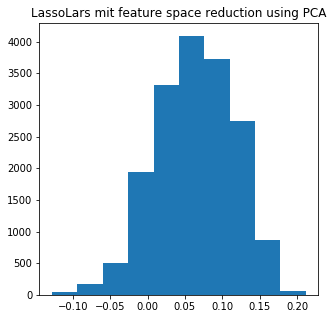

In [7]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_norm.h5ad")
gtex = p.load(file)

((X_train, Y_train, _, _), (X_valid, Y_valid, _, _), (X_test, Y_test, _, _)) = cross(gtex)

%time pred = fit_linear_regression(X_train, Y_train, X_valid, Y_valid)

- PCA using 5 components

In [4]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.load(file)
(X_train, Y_train, _, _), (X_valid, Y_valid, _, _), (X_test, Y_test, _, _) = cross(gtex)

Total Genes:  19932
samples_df  (8911, 14)
samples_df_sliced  (5389, 14)
compute all arrangements
Total pairs: 105778
samples_df  (8911, 14)
samples_df_sliced  (1820, 14)
compute all arrangements
Total pairs: 34830
samples_df  (8911, 14)
samples_df_sliced  (1702, 14)
compute all arrangements
Total pairs: 31308


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


R2:  0.008535853530573227


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 3h 35min 35s, sys: 26min 15s, total: 4h 1min 50s
Wall time: 22min 17s


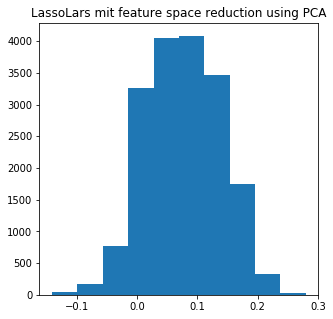

In [14]:
%time pred = fit_linear_regression(X_train, Y_train, X_valid, Y_valid, 5)

- PCA + Randomized SVD

R2:  -561.2704373683409


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 2h 25min 31s, sys: 2min 23s, total: 2h 27min 55s
Wall time: 12min 23s


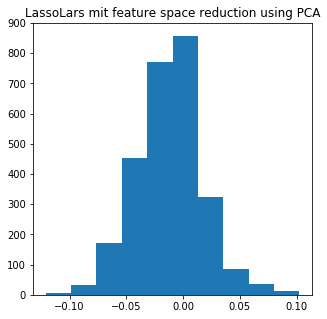

In [5]:
%time pred = fit_linear_regression(X_test[:100], Y_test[:100], X_valid, Y_valid, 5)

 - Do other space reduction - pca = SparsePCA(n_components = comp, batch_size = 100, shuffle = False, n_iter = 10)

(Xs,Ys) = 

In [ ]:
%time pred = fit_linear_regression(X_train[:10], Y_train[:1], X_valid, Y_valid[:1], 10)

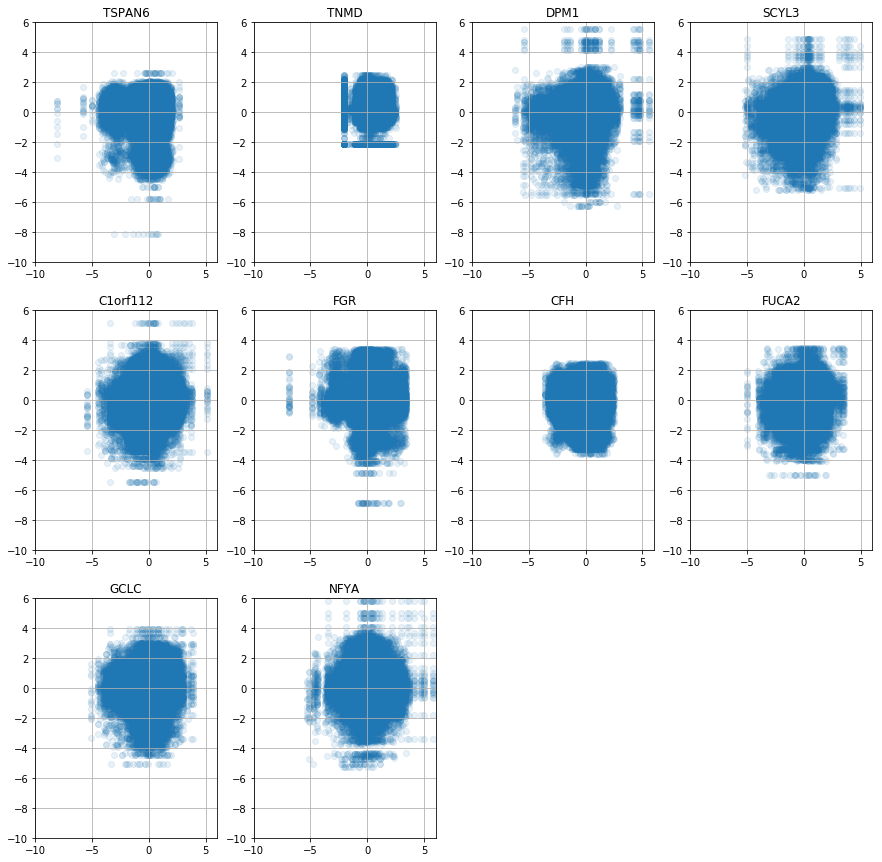

In [129]:
# plot per gene X_train/Y_strain - normalized - first 10 genes
# this represent all combinations of tissues per invidiual
# plot shows all individuals
plt.figure(figsize=(15,15))
ensembl = gene_id_train
for i in range(10):
    plt.subplot(3,4,(i+1))
    plt.scatter(Xs[:,i],Ys[:,i], alpha=0.1)
    plt.xlim((-10, 6))
    plt.ylim((-10, 6))
    plt.title(gtex[ensembl[i]].obs['symbol'].tolist()[0])
    plt.grid(True)

- Build multioutput - multivariate - regression

In [18]:
# Expected Prediction - mean per gene
Y_mean = np.zeros(Y_valid.shape)
for i in range(Y_valid.shape[1]):
    Y_mean[:,i] = np.mean(np.square(Y_valid[:,i]))
Y_mean = np.log10(Y_mean + 1)

In [14]:
# Expected Prediction - mean per tissue accross individuals for each gene
Y_valid = p.readh5('Y_valid.h5')
Y_mean_tissue = np.zeros(Y_valid.shape)
visited = []

for i, s in enumerate(samples_description_valid):
    if s not in visited:
        tissue = filtered_gtex.var.loc[s.split("_")[1],'Tissue']
        ii, ms = zip(*[(k, j) for k,j in enumerate(samples_description_valid) if filtered_gtex.var.loc[j.split("_")[1],'Tissue'] == tissue])
        indexes = list(ii)
        matched_samples = list(ms)
        mean_value = np.mean(np.square(Y_valid[indexes,:]),axis=0)
        new_values =  np.array(mean_value.squeeze() * (Y_mean_tissue[indexes,:].shape[0]))
        Y_mean_tissue[indexes,:] = new_values
        visited += matched_samples
        print(len(visited)," processed out of ", Y_mean_tissue.shape[0])
p.writeh5(Y_mean_tissue,"Baseline_valid","Y_baseline_valid.h5")

In [7]:
# Expected Prediction - mean per tissue accross individuals for each gene
Y_valid = p.readh5('Y_test.h5')
Y_mean_tissue = np.zeros(Y_valid.shape)
visited = []

for i, s in enumerate(samples_description_test):
    if s not in visited:
        tissue = filtered_gtex.var.loc[s.split("_")[1],'Tissue']
        ii, ms = zip(*[(k, j) for k,j in enumerate(samples_description_test) if filtered_gtex.var.loc[j.split("_")[1],'Tissue'] == tissue])
        indexes = list(ii)
        matched_samples = list(ms)
        mean_value = np.mean(np.square(Y_valid[indexes,:]),axis=0)
        new_values =  np.array(mean_value.squeeze() * (Y_mean_tissue[indexes,:].shape[0]))
        Y_mean_tissue[indexes,:] = new_values
        visited += matched_samples
        print(len(visited)," processed out of ", Y_mean_tissue.shape[0])
p.writeh5(Y_mean_tissue,"Baseline_valid","Y_baseline_test.h5")

In [24]:
import os
os.getcwd()

'/data/nasif12/home_if12/giurgiu/rep_gagneur/rep/notebooks/models'

- Normalize data

In [5]:
X_valid = p.readh5('X_valid.h5')
Y_valid = p.readh5('Y_valid.h5')
X_test = p.readh5('X_test.h5')
Y_test = p.readh5('Y_test.h5')

In [6]:
x_preproc = StandardScaler()
y_preproc = StandardScaler()
%time Xs = x_preproc.fit_transform(X_valid)
Ys = y_preproc.fit_transform(Y_valid)
%time Xs_valid = x_preproc.transform(X_test)
Ys_valid = y_preproc.transform(Y_test)

del X_valid, X_test, Y_valid, Y_test

CPU times: user 1.67 s, sys: 291 ms, total: 1.96 s
Wall time: 513 ms
CPU times: user 446 ms, sys: 36.4 ms, total: 482 ms
Wall time: 122 ms


In [11]:
del filtered_gtex

In [4]:
import h5py
h5f = h5py.File('Xs.h5', 'w')
h5f.create_dataset('Xs', data=Xs)
h5f.close()

h5f = h5py.File('Ys.h5', 'w')
h5f.create_dataset('Ys', data=Ys)
h5f.close()

h5f = h5py.File('Xs_valid','w')
h5f.create_dataset('Xs_valid', data=Xs_valid)
h5f.close()

h5f = h5py.File('Ys_valid.h5', 'w')
h5f.create_dataset('Ys_valid', data=Ys_valid)
h5f.close()

In [28]:
from scipy import sparse

In [53]:
def train_lassolars_model(train_x, train_y):
    train_x[1,:] = train_x[1,:] + 0.001
    train_y[1,:] = train_y[1,:] + 0.001
     
    print("LassoLars Regressor")
    reg = MultiOutputRegressor(LassoLarsCV(cv=5, n_jobs=10, max_iter=50, normalize=False), n_jobs = 10)
    
    print("samples x features to fit: ", train_x.shape)
    reg.fit(train_x,train_y) 
    
    return reg

def predict_lasso(reg,predict_x):
    predict_y = reg.predict(predict_x)
    
    
#     predict_y = np.zeros(predict_x.shape)
#     for i in range(train_x.shape[1]):
#         if i % 100 == 0 : print(i)
#         reg = LassoLarsCV(cv=5, n_jobs=10, max_iter=5, normalize=False)
#         reg.fit(train_x,train_y[:,i])   
#         predict_y[:,i] = reg.predict(predict_x)
    return predict_y

In [16]:
%time pred = train_lassolars_model(Xs[:5000,:], Ys[:5000,:], Xs_valid)

In [18]:
pred.shape

(31308, 1000)

In [15]:
%time pred = train_lassolars_model(Xs[:1000,:], Ys[:1000,:], Xs_valid)

LassoLars Regressor
samples x features to fit:  (1000, 1000)
CPU times: user 7.4 s, sys: 544 ms, total: 7.94 s
Wall time: 2min 26s


In [18]:
%time pred = train_lassolars_model(readfile('Xs.h5'),readfile('Ys.h5'), readfile('Xs_valid'))

LassoLars Regressor
(34830, 1000)


TypeError: list indices must be integers or slices, not tuple

In [51]:
reg = []

In [68]:
%%time
reg = []
for i in range(0,Xs.shape[0],100):
    if i + 100 < Xs.shape[0]:
        reg.append(train_lassolars_model(Xs[i:i+100,:], Ys[i:i+100,:]))
    else:
        reg.append(train_lassolars_model(Xs[i:,:], Ys[i:,:]))

LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features to fit:  (100, 1000)
LassoLars Regressor
samples x features t

In [69]:
%%time
for i in range(len(reg[0].estimators_)):
    e = np.zeros((1000))
    intercept = 0
    for r in reg:
        e += r.estimators_[i].coef_
        intercept +=  r.estimators_[i].intercept_
    
    reg[0].estimators_[i].coef_ = e/len(reg[0].estimators_)
    reg[0].estimators_[i].intercept_ = intercept/len(reg[0].estimators_)

pred = predict_lasso(reg[0],Xs_valid)

CPU times: user 4.35 s, sys: 356 ms, total: 4.71 s
Wall time: 1min 49s


In [70]:
p.writeh5(pred,'pred','pred_21_01')

In [ ]:
def evaluate(y_pred,y_valid):
    # evaluate model
    print("R2: ",r2_score(y_valid, y_pred))
    
    plt.figure(figsize=(15,15))
    plt.subplot(3,4,(i+1))
    performances = pd.Series([spearmanr(y_valid[:,i], y_pred[:, i])[0]  for i in range(y_pred.shape[1])])
    plt.hist(performances.dropna())
    plt.title(model)

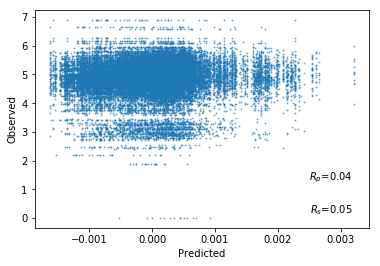

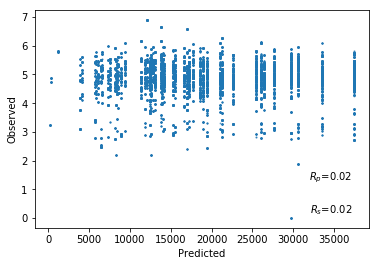

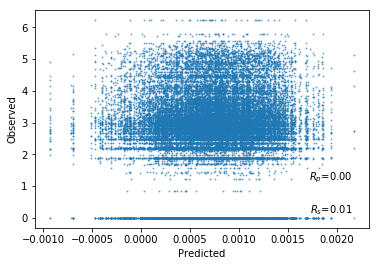

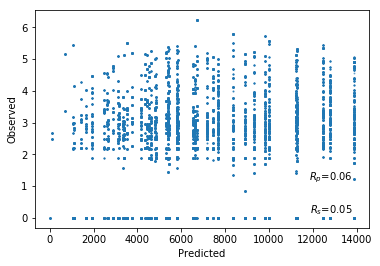

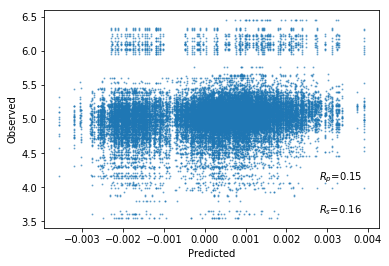

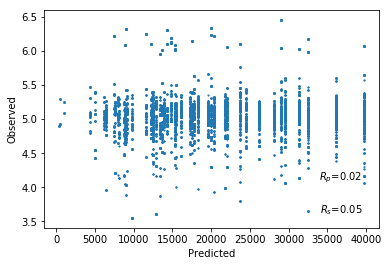

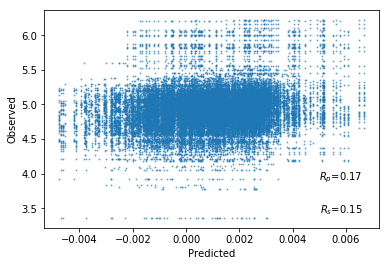

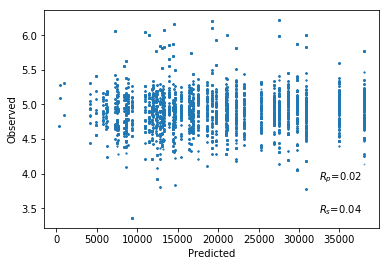

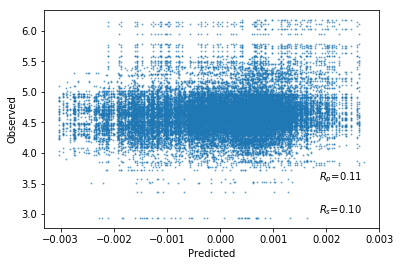

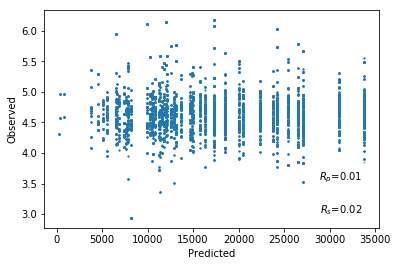

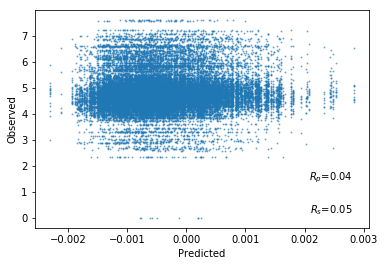

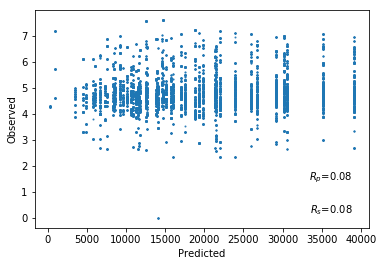

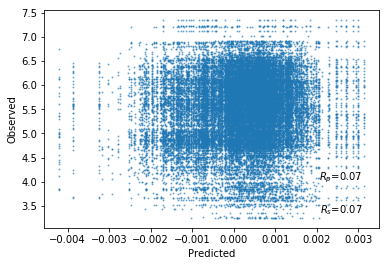

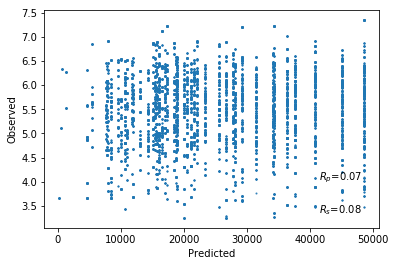

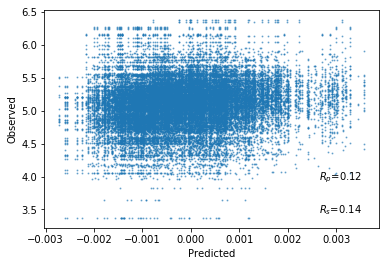

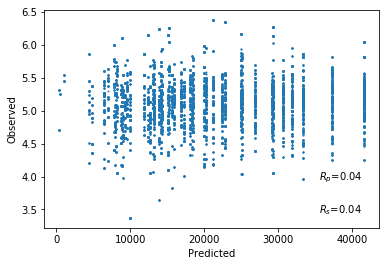

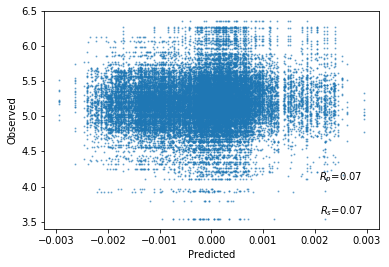

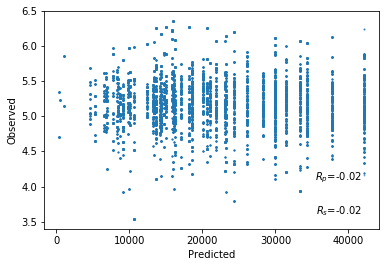

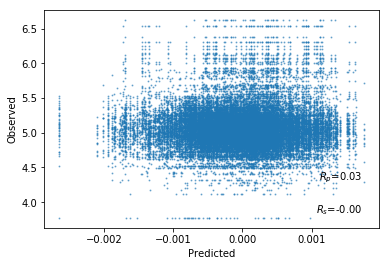

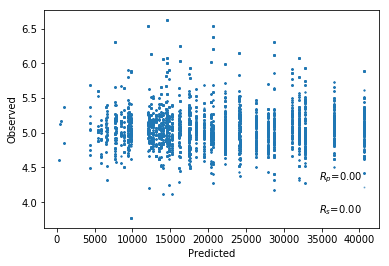

In [14]:
p_true = p.readh5('Y_test.h5')
p_pred = p.readh5('pred_21_01')
p_baseline = p.readh5('Y_baseline_test.h5')
for i in range(10):
    regression_eval(p_true[:,i],p_pred[:,i]),regression_eval(p_true[:,i],p_baseline[:,i])

In [ ]:
#dict_models = {'LassoLars':LassoLars,'LassoLarsCV':LassoLarsCV,'Lasso':Lasso}
dict_models = {'LassoLarsCV':LassoLarsCV}

#'GradientBoostingRegressor':GradientBoostingRegressor}
no_norm = ['GradientBoostingRegressor']

plt.figure(figsize=(15,15))

# run LassoLars
# m = MultiOutputRegressor(LassoLars(), n_jobs = 1)
# %time m.fit(Xs, Ys)
# %time Y_pred = m.predict(Xs_valid)
# print("R2: ",r2_score(Ys_valid, Y_pred))
# print("R2 compare to mean exp model: ",r2_score(Y_mean, Y_pred))
# # Get the performance for all the genes
# plt.subplot(3,4,1)
# performances = pd.Series([spearmanr(Ys_valid[:,i], Y_pred[:, i])[0]  for i in range(Y_pred.shape[1])], index=gene_id_valid)
# plt.hist(performances.dropna())
# plt.title(model)

# m = LassoLarsCV(cv=5,max_iter=15,normalize=False)
# Y_pred = np.zeros(Y_valid.shape)
# for i in range(Ys.shape[1]):
#     # run LassoLarsCV
#     print("Fit for gene: ",i," name ",gene_id_valid[i])
#     %time m.fit(Xs, Ys[:,i])
#     %time Y_pred[:,i] = m.predict(Xs_valid)

# print("R2: ",r2_score(Ys_valid, Y_pred))
# print("R2 compare to mean exp model: ",r2_score(Y_mean, Y_pred))
    
# # Get the performance for all the genes
# plt.subplot(3,4,2)
# performances = pd.Series([spearmanr(Ys_valid[:,i], Y_pred[:, i])[0]  for i in range(Y_pred.shape[1])], index=gene_id_valid)
# plt.hist(performances.dropna())
# plt.title("LassoLarsCV")

# Lasso
# m = MultiOutputRegressor(Lasso(alpha=0.5,normalize=False), n_jobs = 1)
# %time m.fit(Xs, Ys)
# %time Y_pred = m.predict(Xs_valid)
# print("R2: ",r2_score(Ys_valid, Y_pred))
# print("R2 compare to mean exp model: ",r2_score(Y_mean, Y_pred))
# # Get the performance for all the genes
# plt.subplot(3,4,3)
# performances = pd.Series([spearmanr(Ys_valid[:,i], Y_pred[:, i])[0]  for i in range(Y_pred.shape[1])], index=gene_id_valid)
# plt.hist(performances.dropna())
# plt.title(model)


import re

i = 0
model = 'LassoLarsCV'
# for i, model in enumerate(dict_models):
print()
print("Run MultiOuputuRegressor: + ", model)
# choose model
if model in no_norm:
    m = MultiOutputRegressor(dict_models[model](), n_jobs = 1)
elif re.search('CV',model):
    print("Model cross validation")
    m = MultiOutputRegressor(dict_models[model](cv=5,max_iter=15,normalize=False), n_jobs = 1)
else:
    m = MultiOutputRegressor(dict_models[model](alpha=0.5,normalize=False), n_jobs = 1)
#         m = MultiOutputRegressor(dict_models[model](normalize=False), n_jobs = 10)

%time m.fit(Xs, Ys)
%time Y_pred = m.predict(Xs_valid)


Run MultiOuputuRegressor: +  LassoLarsCV
Model cross validation


In [ ]:
# evaluate model
print("R2: ",r2_score(Ys_valid, Y_pred))
print("R2 compare to mean exp model: ",r2_score(Y_valid, Y_mean_tissue))
# Get the performance for all the genes
plt.subplot(3,4,(i+1))
performances = pd.Series([spearmanr(Ys_valid[:,i], Y_pred[:, i])[0]  for i in range(Y_pred.shape[1])], index=gene_id_valid)
plt.hist(performances.dropna())
plt.title(model)
#     regression_eval(Ys_valid, Y_pred)

In [185]:
r2_score(y_test, y_pred)

((105778, 100), (105778, 100))

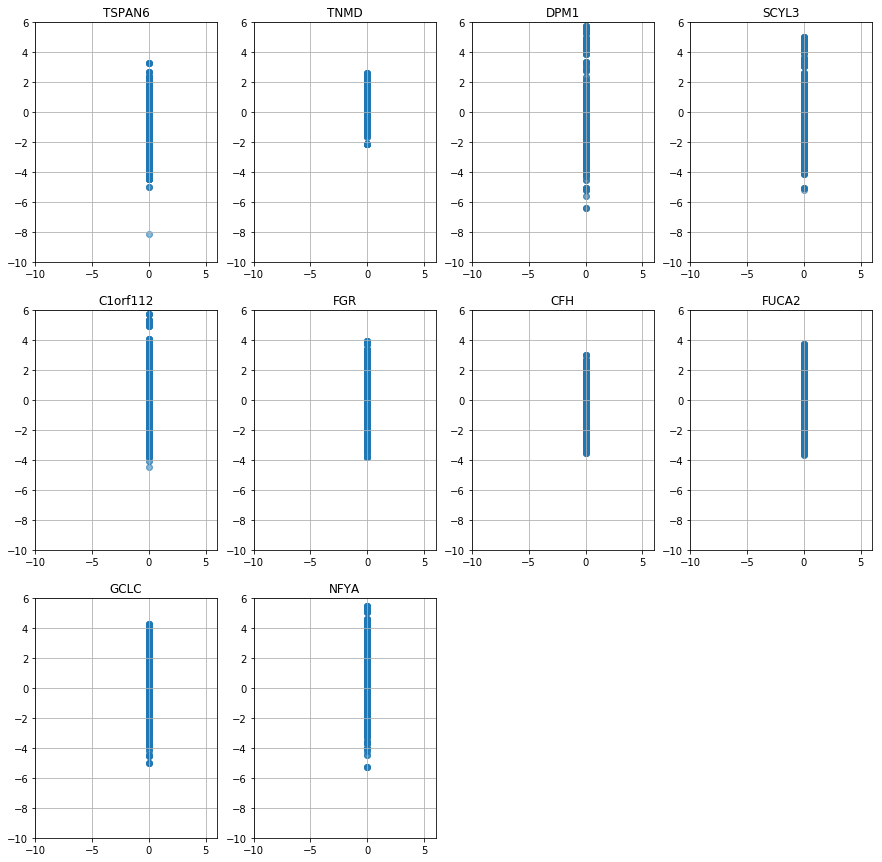

In [72]:
plt.figure(figsize=(15,15))
ensembl = X_train.columns.tolist()
for i in range(10):
    plt.subplot(3,4,(i+1))
    plt.scatter(Y_pred[:,i],Ys_valid[:,i], alpha=0.1)
    plt.xlim((-10, 6))
    plt.ylim((-10, 6))
    plt.title(gtex[ensembl[i]].obs['symbol'].tolist()[0])
    plt.grid(True)

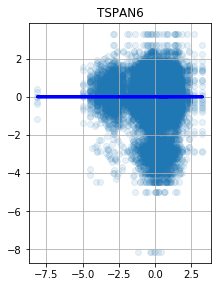

In [73]:
plt.figure(figsize=(15,15))
ensembl = X_train.columns.tolist()
plt.subplot(3,4,1)
plt.scatter(Xs_valid[:,0],Ys_valid[:,0], alpha=0.1)
plt.plot(Xs_valid[:,0], Y_pred[:,0], color='blue', linewidth=3)
plt.yscale('linear')
plt.title(gtex[ensembl[0]].obs['symbol'].tolist()[0])
plt.grid(True)